In [1]:
import mne_bids
from glob import glob
import mne
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from mne.parallel import parallel_func


import mvEEG
import matplotlib.pyplot as plt
import tqdm as tqdm
import scipy.stats as sista
%load_ext autoreload
%autoreload 2

c:\Users\Darius\.conda\envs\mvload\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [233]:
ROOT = r"E:\datasets\supracapacity\derivatives"
DATA_DIR = ROOT

EXPERIMENT_NAME='supracapacity'

dropped_chans={
    'eeg':['Fp1','Fp2'],
    'eog':'ALL',
    'eyegaze':'ALL',
    'pupil':'ALL',
    'misc':'ALL'
}

conditions = ['memory/ss2/no_placeholders',
                'memory/ss4/no_placeholders',
                'memory/ss6/no_placeholders',
                'memory/ss8/no_placeholders',
                'attention/ss2/no_placeholders',
                'attention/ss4/no_placeholders',
                'attention/ss6/no_placeholders',
                'attention/ss8/no_placeholders']



training_groups = [('attention','ss2'),('attention','ss4')]
testing_groups =  [('attention','ss2'),('attention','ss4'),('memory','ss2'),('memory','ss4')]




In [234]:
wrangl = mvEEG.Wrangler(data_dir=DATA_DIR,experiment_name=EXPERIMENT_NAME,dropped_chans=dropped_chans,conditions=conditions,training_groups=training_groups,testing_groups=testing_groups,n_folds=1000)
clfr = mvEEG.Classifier(labels = [v for v in wrangl.group_dict.values()])
RUN_DESCRIPTION="ATT2v4testMEM2v4"


In [245]:

for isub in tqdm.tqdm(range(wrangl.nsub)):
    
    try:
        Xdata,ydata = wrangl.load_eeg(isub,reject=False)
    except:
        continue

    sub_path = mne_bids.BIDSPath(root=ROOT,task=EXPERIMENT_NAME,subject=wrangl.subs[isub],datatype='classification',description=RUN_DESCRIPTION,extension='.npy',check=False)
    sub_path.mkdir()

    parallel,p_func,_ = parallel_func(clfr.decode_across_time,n_jobs = -1)

    out = parallel(
        p_func(
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
        )
        for X_train,X_test,y_train,y_test in wrangl.bin_and_split(Xdata,ydata)
    )
    acc,acc_shuff,conf_mat,confidence_scores = map(np.stack,zip(*out))

    for suffix,array in zip(['accuracy','shuffledAccuracy','confusionMatrix','confidenceScores'],[acc,acc_shuff,conf_mat,confidence_scores]):
        sub_path.update(suffix=suffix)
        np.save(sub_path.fpath,array)
    sub_path.update(suffix='times')
    np.save(sub_path.fpath,wrangl.t)



 35%|███▌      | 11/31 [07:01<12:45, 38.28s/it]


KeyboardInterrupt: 

In [295]:
interp = mvEEG.Interpreter(data_dir = ROOT,
                     experiment_name=EXPERIMENT_NAME,
                     labels=['A2','A4','M2','M4'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


% timepoints significant: 0.0 (0/55)%


<Axes: xlabel='Time from stimulus onset (ms)', ylabel='Classification accuracy'>

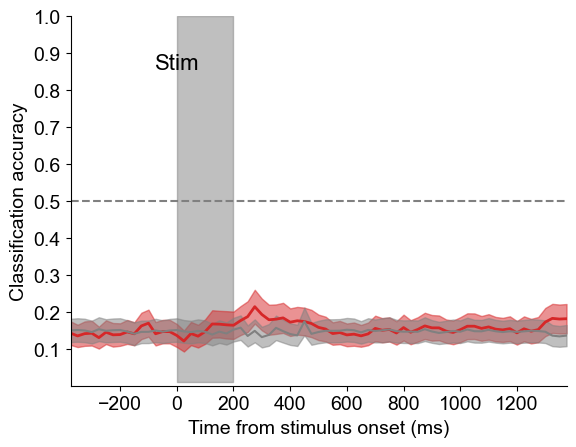

In [293]:
interp.plot_acc(significance_testing=True)

% timepoints significant for A2 vs A4 (alternative = two-sided): 1.82 (1/55)%


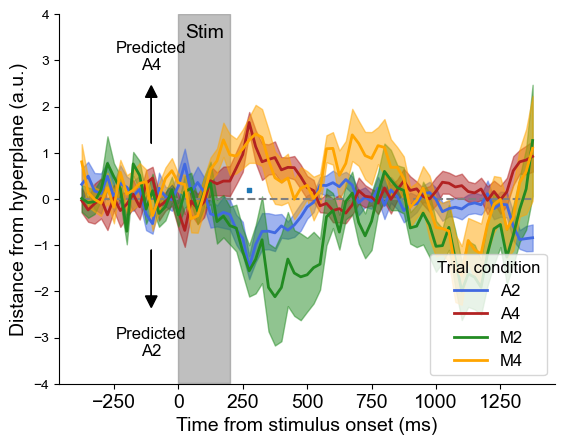

In [298]:
interp.plot_hyperplane(labels=['A2','A4','M2','M4'],significance_testing=True,alternatives=['two-sided'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


% timepoints significant: 36.36 (20/55)%


<Axes: xlabel='Time from stimulus onset (ms)', ylabel='Hyperplane Contrast (a.u.)'>

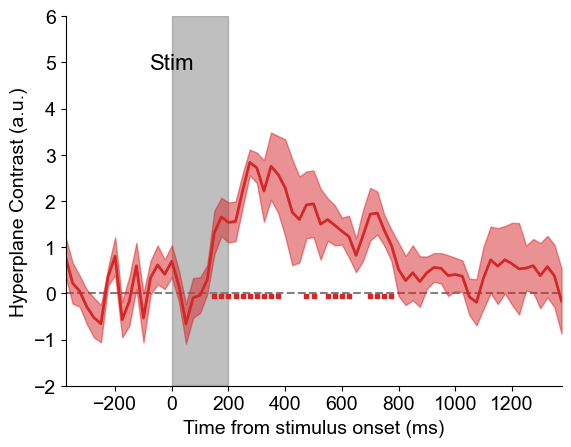

In [305]:
interp.plot_hyperplane_contrast(significance_testing=True,ylim=[-2,6],pair=('M2','M4'))

In [314]:
interp._get_pair_from_label((('A2','A4'),('M2','M4'))[1])

[2, 3]

% timepoints significant: 1.82 (1/55)%
% timepoints significant: 36.36 (20/55)%


<Axes: xlabel='Time from stimulus onset (ms)', ylabel='Hyperplane Contrast (a.u.)'>

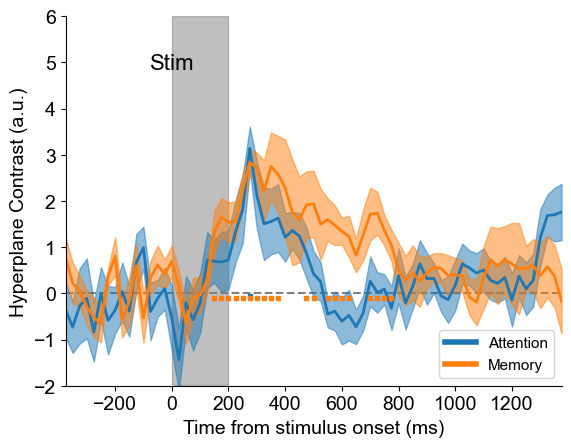

In [324]:
interp.plot_2_contrasts(dsets=['ATT2v4testMEM2v4'] * 2,pairs=(('A2','A4'),('M2','M4')),labels=['Attention','Memory'],significance_testing=True,ylim=[-2,6],significance_between=True,sig_y_between=3)

              T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.68493    9   two-sided  0.126285  [-1.21, 0.18]  0.683354  0.894   

           power  
T-test  0.487841  


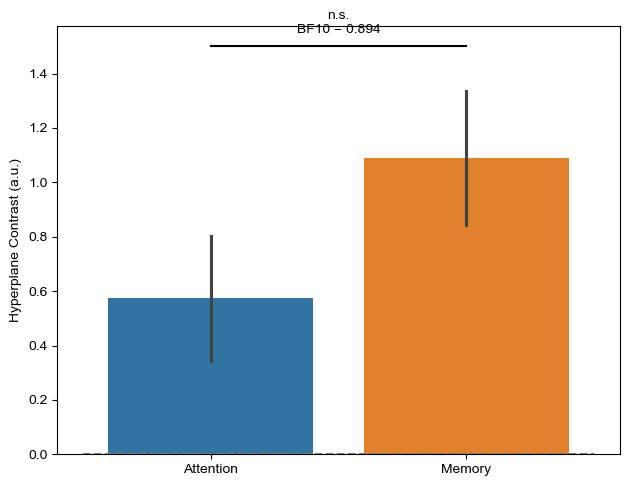

In [342]:
contrasts = interp.plot_2_contrasts_bar(dsets=['ATT2v4testMEM2v4'] * 2,pairs=(('A2','A4'),('M2','M4')),labels=['Attention','Memory'],significance_between=True,sig_y = 1.5)


<Axes: title={'center': 'Predicted Label'}, ylabel='True Label'>

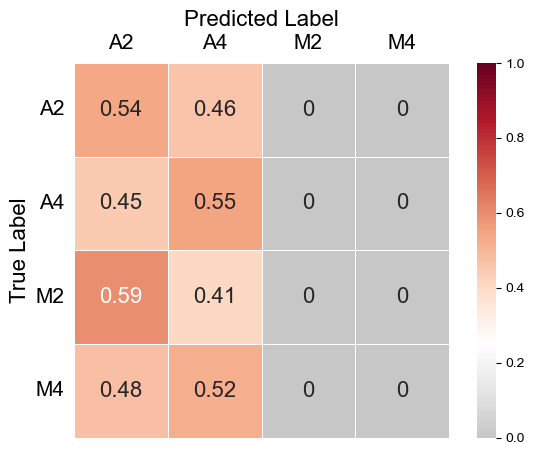

In [307]:
interp.plot_confusion_matrix()